# 이미지 분류기 구축

## Dataset: FashionMNIST

### 이미지 크기: 28x28 (Gray-scale images of 28x28 pixels)

## 1. Load FashionMNIST

In [1]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [2]:
# FashionMNIST 데이터셋 불러오기

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

In [3]:
# DataLoader (cpu 환경이므로 batch size를 예외적으로 작게 설정)

batch_size = 4

# 학습 반복 동안 mini-batch의 구성이 계속해서 달라지도록 shuffle=True로 설정
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                          shuffle=True)

# Test 시에는 mini-batch 구성의 순서가 상관없으므로 shuffle=False로 설정
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

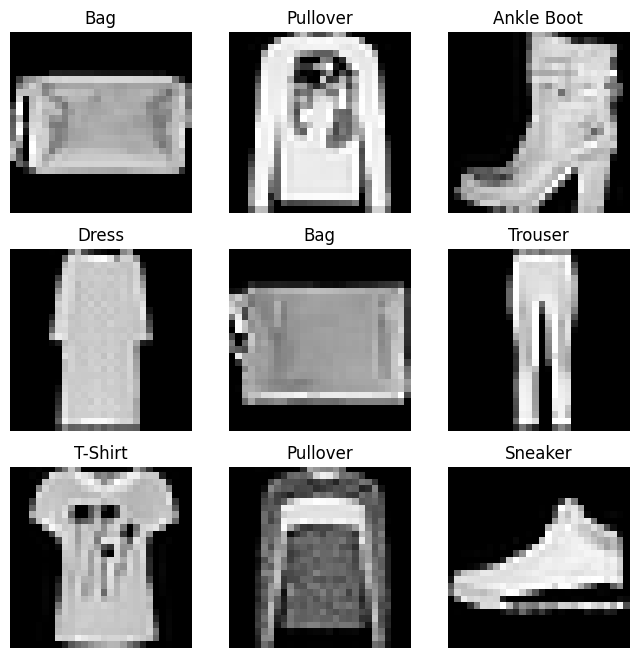

In [4]:
# 데이터 시각화 해보기

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

shape of image: torch.Size([1, 28, 28])
label: 9


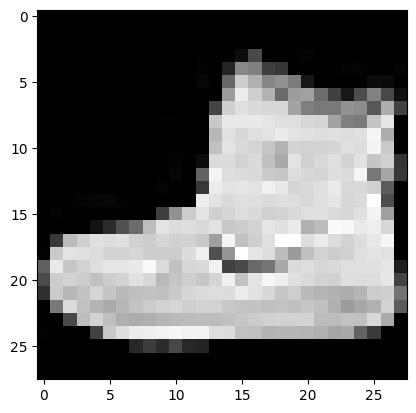

In [5]:
# 이미지 shape와 출력 예시 확인

img, label = trainloader.dataset[0]
print('shape of image:', img.shape)
print('label:', label)
plt.imshow(img.squeeze(), cmap="gray")

## 2. Define a Convolutional Neural Network

In [ ]:
# 모델 정의

import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolution 함수 정의
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=8, kernel_size=3)

        # nonlinearity - ReLU 함수 정의
        self.relu = nn.ReLU()

        # Pooling 함수 정의
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully-connected layer 함수 정의
        self.fc1 = nn.Linear(8 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        

    def forward(self, x):
        #Conv layer 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        #Conv layer 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # flatten all dimensions except batch
        x = torch.flatten(x, 1)

        # fully-connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x


net = Net()

## 3. Define a Loss Function and Optimizer

In [ ]:
# hyperparameter 설정

learning_rate = 1e-3
num_epochs = 5

In [ ]:
# loss function 및 optimizer 설정

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

## 4. Train the Network

In [ ]:
# 여러 epoch을 반복하며 CNN 모델 학습

for epoch in range(num_epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        

        if i % 1000 == 0:
            if i > 0:
                print('epoch: %d, iter: %d, loss: %.3f'%((epoch+1), i, running_loss/1000))
                running_loss = 0.0
    
    print('%d epoch processed...'%(epoch+1))

print('Finished Training')

In [ ]:
# 학습된 모델 저장하기

PATH = './fashionmnist_convnet.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
# 저장된 모델의 Parameter 불러오기

net = Net()
net.load_state_dict(torch.load(PATH))

## 5. Test the Network on the Test Data

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
# 전체 test set에 대한 accuracy

pred_list = []
labels_list = []

# 모델 학습을 종료하였으므로 gradient 계산을 할 필요가 없음
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        # 샘플 이미지에 대한 model output 출력
        outputs = net(images)
        
        # model output에 기반한 예측 결과 출력
        pred = outputs.argmax(1)

        
        pred_list.append(pred)
        labels_list.append(labels)


pred_list = np.hstack(pred_list)
labels_list = np.hstack(labels_list)

acc = accuracy_score(pred_list, labels_list)

print('Accuracy of the network on the 10000 test images:', acc)

In [ ]:
# Test set 샘플 이미지 출력해보기

# batch size 만큼의 이미지 샘플 추출
dataiter = iter(testloader)
images, labels = next(dataiter)


# print images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    
imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join(f'{labels_map[labels[j]]:5s}' for j in range(batch_size)))

ground_truth_list = []
for label in labels:
    true_label = labels_map[label.item()]
    ground_truth_list.append(true_label)

print('Ground Truth:', ground_truth_list)

In [ ]:
# 샘플에 대한 예측 수행 후 실제 값과 일치하는 지 비교해보기

outputs = net(images)

preds = outputs.argmax(1)

pred_label_list = []
for pred in preds:
    pred_label = labels_map[pred.item()]
    pred_label_list.append(pred_label)

print('Predicted: ', pred_label_list)